Data preprocessing is an umbrella term that covers an array of operations data scientists will use to get their data into a form more appropriate for what they want to do with it. For example, before performing sentiment analysis of twitter data, you may want to strip out any html tags, white spaces, expand abbreviations and split the tweets into lists of the words they contain. When analyzing spatial data you may scale it so that it is unit-independent, that is, so that your algorithm doesn't care whether the original measurements were in miles or centimeters. However, preprocessing data does not occur in a vacuum. This is just to say that preprocessing is a means to an end and there are no hard and fast rules: there are standard practices, as we shall see, and you can develop an intuition for what will work but, in the end, preprocessing is generally part of a results-oriented pipeline and its performance needs to be judged in context.

In this article, I'll use the example of scaling numerical data (numerical data: data consisting of numbers, as opposed to categories/strings; scaling: using basic arithmetic to change the range of the data; more details to follow) to demonstrate the importance of considering preprocessing as part of a greater structure, the machine learning (ML) pipeline. To this end, we'll see a real-world example in which scaling can improve model performance.

I'll first introduce classification problems in ML and k-Nearest Neighbors, one of the simplest algorithms used in such settings. To appreciate the importance of scaling numerical data in such a setting, I'll need to introduce measures of model performance and the concepts of training and test sets. You'll see all these concepts and practices at play with a dataset in which I attempt to classify the quality of red wine. I'll also make sure that I put preprocessing in its most useful place, near the beginning of an iterative data science pipeline. All examples herein will be in Python. If you're not familiar with Python, you can check out our DataCamp courses <a href = 'https://www.datacamp.com/'>here</a>. I will make use of the libraries <a href = 'http://pandas.pydata.org/'>pandas</a> for our dataframe needs and <a href = 'http://scikit-learn.org/stable/'>scikit-learn</a> for our machine learning needs.

### A brief introduction to classification problems in machine learning

Classifying and labelling things in the phenomenal world is an ancient art. In the 4th century BC, Aristotle constructed a classification system of living things that was used for 2,000 years. In the modern world, classification is commonly framed as a machine learning task, in particular, a supervised learning task. The basic principle of supervised learning is straightforward: we have a bunch of data consisting of *predictor variables* and a *target variable*. The aim of **supervised learning** is to build a model that is 'good at' predicting the target variable, given the predictor variables. If the target variable consists of categories (e.g. 'click' or 'not', 'malignant' or 'benign' tumor), we call the learning task **classification**. Alternatively, if the target is a continuously varying variable (e.g. price of a house), it is a **regression** task. 

An illustrative example will go a long way here: consider the <a href='http://archive.ics.uci.edu/ml/datasets/Heart+Disease'>heart disease dataset</a>, in which there are 75 predictor variables, such as 'age', 'sex' and 'smoker or not' and the target variable refers to the presence of heart disease and ranges from 0 (no heart disease) to 4. Much work on this dataset has concentrated on attempts to distinguish the presence of heart disease from its absence. This is a classification task. If you were to attempt to predict the actual value (0 to 4) of the target variable, this would be a regression problem (because the target variable is ordered). I'll discuss regression in the next post. Here I'll look at one of the simplest algorithms for classification tasks, the **k-Nearest Neighbors algorithm**.

#### k-Nearest Neighbors for classification in machine learning

Let's say that we have some labeled data, for example, data that consists of characteristics of red wine (e.g. alcohol content, density, amount of citric acid, pH, etc...; these are the predictor variables) with target variable 'Quality' and labels 'good' & 'bad'. Then, given the characteristics of a new, unlabeled wine, the classification task is to predict its 'Quality'. When all the predictor variables are numerical (there are also ways to deal with the categorical case), we can consider each row/wine as a point in n-dimensional space and, in this case, k-Nearest Neighbors (k-NN) is a conceptually & computationally simple classification method: for each new, unlabeled wine, we calculate, for some integer k, its k nearest neighbors in the n-dimensional predictor variable space. Then we look at the labels of these k neighbors (i.e. 'good' or 'bad') & assign the label with the most hits to the new wine (e.g. if k = 5, 3 neighbors vote 'good' and 2 vote 'bad', then our model labels the new wine 'good'). Note that, here, training the model consists entirely in storing the data points: there are no parameters to fit!

#### A visual description of k-Nearest Neighbors

In the image below, there's an example of k-NN in 2D: how do you classsify the data point in the middle? Well, if k=3, you would clasify it as red and, if k=5, as green. 

In [1]:
from IPython.display import Image
Image(url= 'http://36.media.tumblr.com/d100eff8983aae7c5654adec4e4bb452/tumblr_inline_nlhyibOF971rnd3q0_500.png')

#### k-NN implementation in Python (scikit-learn)

Let's now see an example of k-NN at work. To do so, we'll check out the <a href='http://archive.ics.uci.edu/ml/datasets/Wine+Quality'>wine quality dataset</a>: we'll import it into a pandas dataframe and then plot histograms of the predictor variables to get a feel for the data.

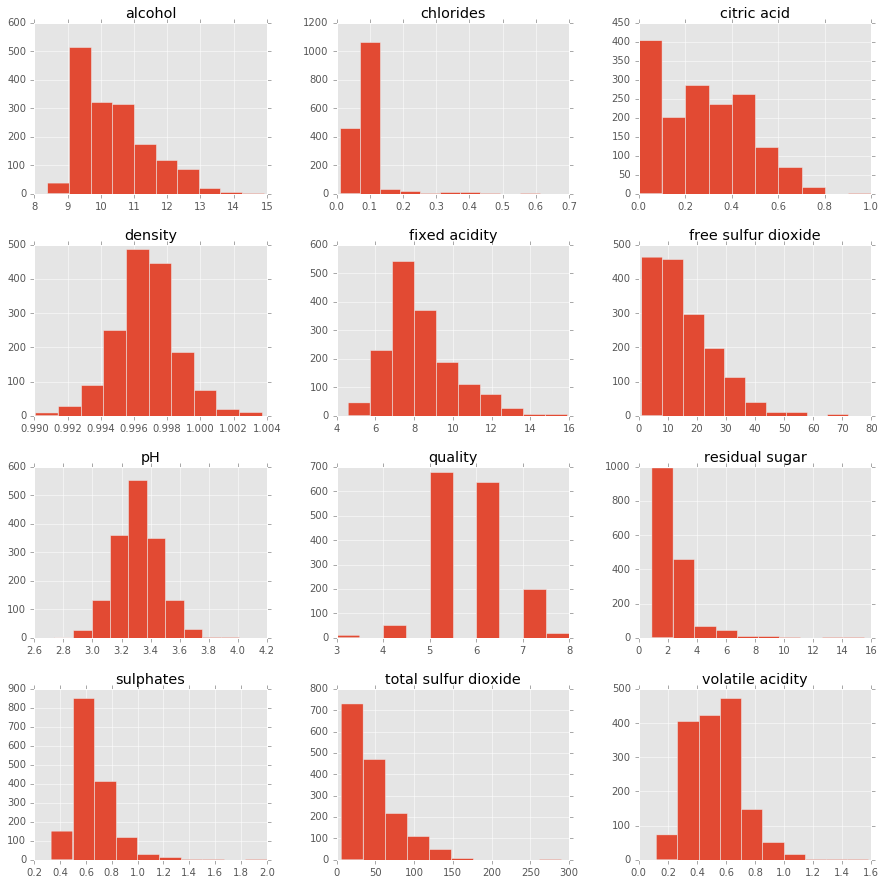

In [2]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv ' , sep = ';')
X = df.drop('quality' , 1).values # drop target variable
y1 = df['quality'].values
pd.DataFrame.hist(df, figsize = [15,15]);

First notice the range of the predictor variables: 'free sulfur dioxide' ranges from 0 to ~70 and 'volatile acidity' from ~0 to ~1.2. More specifically, the former has a range 2 orders of magnitude larger than that of the latter. Any algorithm, such as k-NN, which cares about the distance between data points, may thus focus squarely and unfairly on variables with a larger range, such as 'free sulfur dioxide', a variable that may contain only noise, for all we know. This motivates scaling our data, which we'll get to soon enough.

Now the target variable is a 'Quality' rating of wine and ranges from 3 to 8. For the purpose of expositional ease, let's turn it into a two-category variable consisting of 'good' (rating > 5) & 'bad' (rating <= 5). We'll also plot histograms of both formulations of the target variable to get a sense of what's going on.

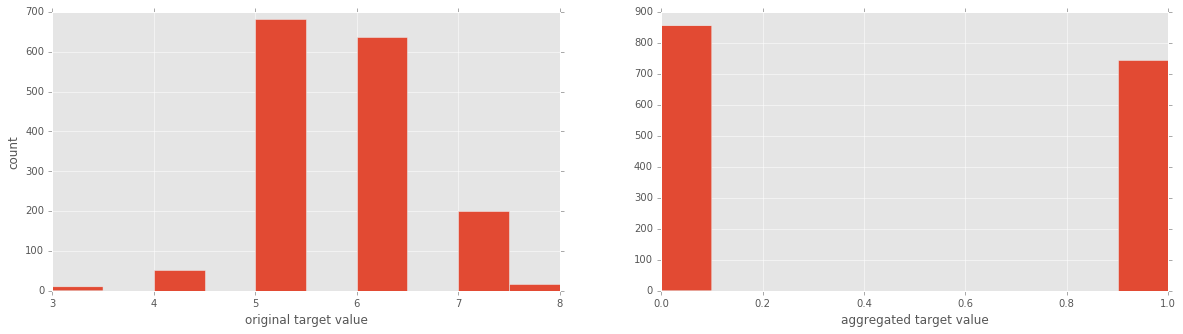

In [3]:
y = y1 <= 5 # is the rating <= 5?
# plot histograms of original target variable
# and aggregated target variable
plt.figure(figsize=(20,5));
plt.subplot(1, 2, 1 );
plt.hist(y1);
plt.xlabel('original target value')
plt.ylabel('count')
plt.subplot(1, 2, 2);
plt.hist(y)
plt.xlabel('aggregated target value')
plt.show()

Now we're nearly ready to perform k-Nearest Neighbors. First off, though, if we're going to compare how our model performs with and without preprocessing, we'll need to figure out how to measure the 'goodness' of a model:

#### k-Nearest Neighbors: how well does it perform?

There are a number of performance measures for classification challenges. It is of the utmost importance to realise that the choice of performance measure is deeply domain & question specific. In the case of a dataset with balanced classes (where all target values are ~ equally represented), data scientists commonly look at *accuracy* as a performance measure. In fact, as we'll see, accuracy is the default scoring method for both k-Nearest Neighbors and logistic regression in scikit-learn. So what is accuracy? It is merely the number of correct predictions divided by the total number of predictions:


$$\text{Accuracy}=\frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}.$$

*Note: **accuracy** can also be defined in terms of a confusion matrix and is commonly defined for binary classification problems in terms of true positives & false negatives; other common measures of model performance derivable from the confusion matrix are **precision**, the number of true positives divided by the number of true & false positives, and **recall**, the number of true positives divided by the number of true positives plus the number of false negatives; yet another measure, the **F1-score** is the harmonic mean of the precision and the recall. See <a href='http://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/'>machine learning mastery</a> for a nice exposition of these measures; also check out the Wikipedia entries on the <a href='https://en.wikipedia.org/wiki/Confusion_matrix'>confusion matrix</a> and the <a href='https://en.wikipedia.org/wiki/F1_score'>F1 score</a>.*

#### k-Nearest Neighbors: performance in practice and the train test split

It is all well and good to have a measure of performance such as accuracy, but if we fit the model on all of the data we have, what dataset are we going we going to report the accuracy from? Remember that we want a model that generalizes well to new data. Thus, if we train our model on a dataset *D*, reporting the accuracy of the model on the same data *D* may make it look as though it performs better than it actually does. This is known as **overfitting**. To combat this issue, data scientists will commonly train their model on a subset of the data, called the **training set** and evaluate its performance on the rest of the data, the **test set**. This is precisely what we're going to do here! A general rule of thumb is to use approximately 80% of the data for training & 20% for test. Let's now split our red wine quality data:

In [4]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We now build the k-NN model, make predictions on the test set and compare these predictions to the ground truth in order to get a measure of model performance:

In [5]:
from sklearn import neighbors, linear_model
knn = neighbors.KNeighborsClassifier(n_neighbors = 5)
knn_model_1 = knn.fit(X_train, y_train)
print('k-NN accuracy for test set: %f' % knn_model_1.score(X_test, y_test))

k-NN accuracy for test set: 0.612500


It is worth reiterating that the default scoring method for k-NN in scikit-learn is *accuracy*. An accuracy of 61% is not great but for an out of the box model without any preprocessing it's not horrible either. To check out a variety of other metrics, we can use scikit-learn's classification report also: 

In [6]:
from sklearn.metrics import classification_report
y_true, y_pred = y_test, knn_model_1.predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

      False       0.66      0.64      0.65       179
       True       0.56      0.57      0.57       141

avg / total       0.61      0.61      0.61       320



Now we're going to introduce scaling and centering, the most basic methods of preprocessing numerical data, and see if and how they effect our model performance.

### The mechanics of preprocessing: scaling and centering

Before running a model, such as regression (predicting a continuous variable) or classification (predicting a discrete variable), on data, you almost always want to do some preprocessing. For numerical variables, it is common to either *normalize* or *standardize* your data. What do these terms mean?

All *normalization* means is scaling a dataset so that its minimum is 0 and its maximum 1. To achieve this we transform each data point $x$ to


$$x_{normalized} = \frac{x-x_{min}}{x_{max}-x_{min}}.$$

*Stardardization* is slightly different; it's job is to center the data around 0 and to scale with respect to the standard deviation:


$$x_{standardized} = \frac{x-\mu}{\sigma},$$

where $\mu$ and $\sigma$ are the mean and standard deviation of the dataset, respectively. First note that these transformations merely change the range of the data and not the distribution. You may later wish to use any other number of transforms, such as a log transform or a Box-Cox transform, to make your data look more Gaussian (like a bell-curve). But before we go further, it is important to ask the following questions: why do we scale our data? Are there times that it is more appropriate than others? For example, is it more important in classification problems than in regression? 

Let's first delve into classification challenges and see how scaling affects the performance of k-Nearest Neighbors:

#### Preprocessing: scaling in practice

Here below I (i) scale the data, (ii) use k-Nearest Neighbors and (iii) check the model performance. I'll use scikit-learn's <a href='http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html'>scale function</a>, which standardizes all features (columns) in the array passed to it.

In [7]:
from sklearn.preprocessing import scale
Xs = scale(X)
from sklearn.cross_validation import train_test_split
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=42)
knn_model_2 = knn.fit(Xs_train, y_train)
print('k-NN score for test set: %f' % knn_model_2.score(Xs_test, y_test))
print('k-NN score for training set: %f' % knn_model_2.score(Xs_train, y_train))
y_true, y_pred = y_test, knn_model_2.predict(Xs_test)
print(classification_report(y_true, y_pred))

k-NN score for test set: 0.712500
k-NN score for training set: 0.814699
             precision    recall  f1-score   support

      False       0.72      0.79      0.75       179
       True       0.70      0.62      0.65       141

avg / total       0.71      0.71      0.71       320



All these measures improved by 0.1, which is a 16% improvement and significant! As hinted at above, before scaling there were a number of predictor variables with ranges of different order of magnitudes, meaning that one or two of them could dominate in the context of an algorithm such as k-NN. The two main reasons for scaling your data are
1. Your predictor variables may have significantly different ranges and, in certain situations, such as when implementing k-NN, this needs to be mitigated so that certain features do not dominate the algorithm;
2. You want your features to be unit-independent, that is, not reliant on the scale of the measurement involved: for example, you could have a measured feature expressed in meters and I could have the same feature expressed in centimeters. If we both scale our respective data, this feature will be the same for each of us.

We have seen the essential place occupied in the data scientific pipeline by preprocessing, in its scaling and centering form, and we have done so to promote a holistic approach to the challenges of machine learning. In future articles, I hope to extend this discussion to other types of preprocessing, such as transformations of numerical data and preprocessing of categorical data, both essential aspects of any data scientists's toolkit. Before moving onto this, in the next article I will explore the role of scaling in regression approaches to classification. In particular, I'll look at logistic regression and you'll see that the result is very different to the one you just saw in the context of k-Nearest Neighbors.

___


In the interactive window below, you can play with the data yourself. Start off by changing the variable *n_neig*, which is the number of neighbors to use in the k-NN algorithm. You can also scale the data by setting *sc = True*, if you desire. Then run the entire script to report the accuracy of the model, along with a classification report.

In [3]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.preprocessing import scale
from sklearn.metrics import classification_report

In [5]:
# Load data
# http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv' , sep = ';')
X = df.drop('quality' , 1).values # drop target variable

In [4]:
# Set the the number of neighbors for k-NN
n_neig = 5
# Set sc = True if you want to scale your features
sc = False

In [6]:
# Here we scale, if desired
if sc == True:
    X = scale(X)

In [7]:
# Target value
y1 = df['quality'].values # original target variable
y = y1 <= 5 # new target variable: is the rating &lt;= 5?

In [8]:
# Split the data into a test set and a training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Train k-NN model and print performance on the test set
knn = neighbors.KNeighborsClassifier(n_neighbors = n_neig)
knn_model = knn.fit(X_train, y_train)
y_true, y_pred = y_test, knn_model.predict(X_test)
print('k-NN accuracy for test set: %f' % knn_model.score(X_test, y_test))
print(classification_report(y_true, y_pred))

k-NN accuracy for test set: 0.612500
              precision    recall  f1-score   support

       False       0.66      0.64      0.65       179
        True       0.56      0.57      0.57       141

   micro avg       0.61      0.61      0.61       320
   macro avg       0.61      0.61      0.61       320
weighted avg       0.61      0.61      0.61       320



In [11]:
Xs = scale(X)
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=42)
knn_model_2 = knn.fit(Xs_train, y_train)
print('k-NN score for test set: %f' % knn_model_2.score(Xs_test, y_test))
print('k-NN score for training set: %f' % knn_model_2.score(Xs_train, y_train))
y_true, y_pred = y_test, knn_model_2.predict(Xs_test)
print(classification_report(y_true, y_pred))

k-NN score for test set: 0.712500
k-NN score for training set: 0.814699
              precision    recall  f1-score   support

       False       0.72      0.79      0.75       179
        True       0.70      0.62      0.65       141

   micro avg       0.71      0.71      0.71       320
   macro avg       0.71      0.70      0.70       320
weighted avg       0.71      0.71      0.71       320



___
### Glossary

**Supervised learning:** The task of inferring a *target variable* from *predictor variables*. For example, inferring the *target variable* 'presence of heart disease' from *predictor variables* such as 'age', 'sex', and 'smoker status'.


**Classification task:** A *supervised learning* task is a *classification task* if the target variable consists of categories (e.g. 'click' or 'not', 'malignant' or 'benign' tumour).

**Regression task:** A *supervised learning* task is a *regression task* if the target variable is a continuously varying variable (e.g. price of a house) or an ordered categorical variable such as 'quality rating of wine'.

**k-Nearest Neighbors:** An algorithm for *classification tasks*, in which a data point is assigned the label decided by a majority vote of its k nearest neighbors.

**Preprocessing:** Any number of operations data scientists will use to get their data into a form more appropriate for what they want to do with it. For example, before performing sentiment analysis of twitter data, you may want to strip out any html tags, white spaces, expand abbreviations and split the tweets into lists of the words they contain.

**Centering and Scaling:** These are both forms of preprocessing *numerical data*, that is, data consisting of numbers, as opposed to categories or strings, for example; *centering* a variable is subtracting the mean of the variable from each data point so that the new variable's mean is 0; *scaling* a variable is multiplying each data point by a constant in order to alter the range of the data. See the body of the article for the importance of these, along with examples.


___

*This article was generated from a Jupyter notebook. You can download the notebook <a href = 'https://github.com/hugobowne/machine_learning_techniques/blob/master/notes_on_ML/K-NN_and_preprocessing.ipynb'>here</a>.*